In [1]:
import numpy as np
from IPython.display import clear_output

In [2]:
from src.machinelearningsuite.machinelearningsuite import MachineLearningSuite

In [3]:
%matplotlib notebook
%gui asyncio
import matplotlib.pyplot as plt
import ipywidgets
import IPython
import PIL.Image
from io import StringIO
from io import BytesIO
from IPython.display import clear_output
import cv2
from time import sleep

In [4]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(array, displayables=[], fmt='jpeg', is_rgb=False):
    if not is_rgb:
        array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)
    f = BytesIO()
    something = PIL.Image.fromarray(array)
    something.save(f, fmt)
    clear_output(wait=True)
    for d in displayables:
        display(d)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    # plt.imshow(a)

In [5]:
suite = MachineLearningSuite("webcam", "../data/shape_predictor_68_face_landmarks.dat")
suite.initialize()

Current configuration:
-----------------------
{'classes': ['closed', 'open'], 'normalizer': Normalizer(copy=True, norm='l2'), 'classifier': None, 'feature-processor': FeatureProcessing(parts=['mouth']), 'data-labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [5]:
suite.configuration.reset()

In [5]:
suite.create_classes()

1. Create classes
Current classes: ['closed', 'open']
Press "q" to stop entering classes
What is the name of class 0 ?q


In [7]:
suite.select_parts()

1. Create classes
Your selection has to be within the following list:
['left-eyebrow', 'right-eyebrow', 'left-eye', 'right-eye', 'nose', 'mouth', 'jaw']
Current face parts: ['mouth']
Press "q" to stop entering face parts
Enter a face part: q


In [6]:
suite.source.release()
def construct_stream():
    return cv2.VideoCapture(0)

In [7]:
def collect_data_for_class(class_index):
    source = construct_stream()
    try:
        while True:
                ret, frame = source.read()
                if type(frame) == type(None):
                    continue
                frame, landmarks = suite.landmark_detector.get_frame_with_landmarks(frame)
                feature_vector = suite.feature_processor.process(landmarks)
                showarray(frame, displayables=["Gathering additional training data for class {}".format(class_index)])
                if feature_vector:
                    suite.configuration.set_data_values(class_index, feature_vector)
    except KeyboardInterrupt:
        source.release()
        print("Stream stopped")
        suite.configuration.save_configuration()

'Gathering additional training data for class 0'

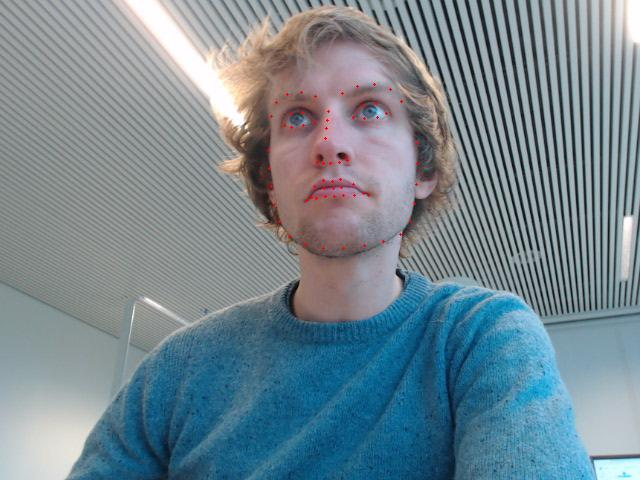

Stream stopped


In [7]:
collect_data_for_class(0)

'Gathering additional training data for class 1'

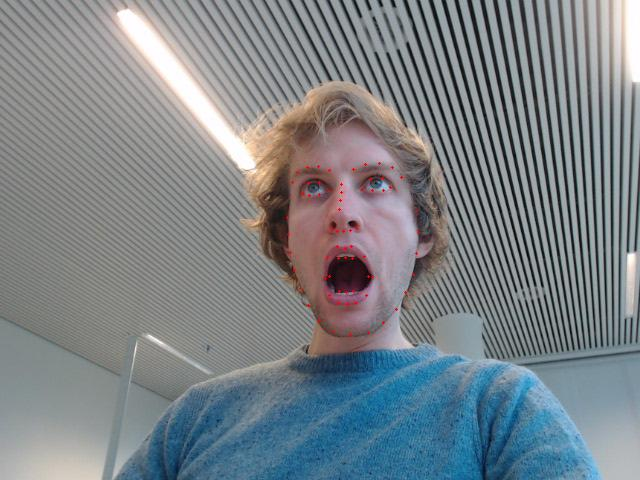

Stream stopped


In [12]:
collect_data_for_class(1)

In [8]:
suite.normalizer.train()
suite.classifier.train()
def predict():
    source = construct_stream()
    try:
        while True:
            ret, frame = source.read()
            if type(frame) == type(None):
                continue
            frame, landmarks = suite.landmark_detector.get_frame_with_landmarks(frame)
            feature_vector = suite.feature_processor.process(landmarks)
            if feature_vector:
                feature_vector = np.asarray(feature_vector).reshape(1, -1)
                feature_vector_normalized = suite.normalizer.normalize(feature_vector)
                # print(np.asarray(feature_vector_normalized).shape[1]/2)
                prediction = suite.classifier.predict(feature_vector_normalized)
                try:
                    predicted_class = suite.configuration.classes[int(prediction[0])]
                    label = predicted_class
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(frame, label, (100, 400), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
                except IndexError:
                    print("This class has no label yet (class index: {})".format(prediction[0]))
            showarray(frame)
    except KeyboardInterrupt:
        source.release()
        print("Stream stopped")

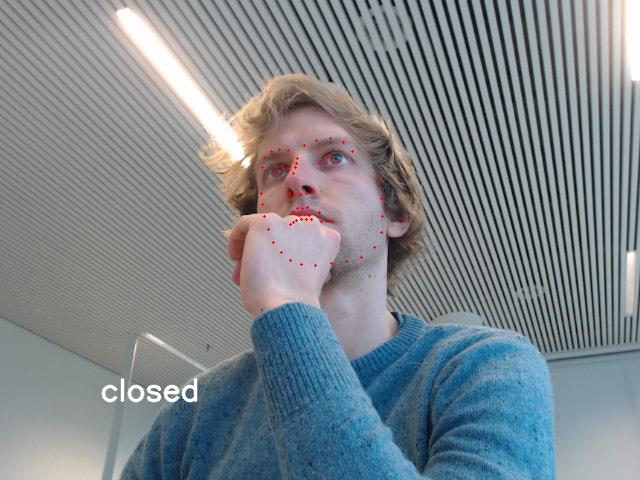

Stream stopped


In [9]:
predict()